## 1. Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Building a Shared Preprocessing Pipeline
Before training any model, I created a preprocessing pipeline that handles both numerical and categorical columns. Numerical features are scaled, and categorical ones are one-hot encoded.  

I kept this preprocessing block “shared” because my professor wants all models to work off the exact same transformed data. That way, if Random Forest performs differently than XGBoost, it’s because of the models themselves and not how the data was prepared.

This step also avoids data leakage and forces all transformations to happen inside the pipeline, which is cleaner and safer.

In [2]:
# Loading the Dataset
df = pd.read_csv("../data/processed/bank_churn_clustered.csv")
print(df.shape)
df.head()

# Defining features and target variable
X = df.drop(columns=['Churn'])
y = df['Churn']


# CRITICAL: Fixed constants for reproducibility across both models
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

# Train-test split (SAME in both files)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

### Preprocessing Pipeline

# determine columns (IDENTICAL in both files)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)
# Shared CV strategy (IDENTICAL in both files)
cv_strategy = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

print(f"Shared preprocessing configured:")
print(f"- Random State: {RANDOM_STATE}")
print(f"- Test Size: {TEST_SIZE}")
print(f"- CV Folds: {CV_FOLDS}")

(10000, 13)
Train shape: (8000, 12)
Test shape: (2000, 12)
Shared preprocessing configured:
- Random State: 42
- Test Size: 0.2
- CV Folds: 5


### Baseline Random Forest Model -> Train Test Split -> Fir the Basline Model 

In [3]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

clf.fit(X_train, y_train)           
# pipeline fits preprocessors then classifier
preds = clf.predict(X_test)

### Baseline Model Evaluation

### Classification Report

In [4]:
# Evaluate model
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1593
           1       0.75      0.41      0.53       407

    accuracy                           0.85      2000
   macro avg       0.81      0.69      0.72      2000
weighted avg       0.84      0.85      0.83      2000



The standard Random Forest model achieves an overall accuracy of **0.85**, which appears impressive at first sight. However, accuracy by itself does not provide the complete picture, particularly in a churn prediction scenario where the classes are uneven. To gauge the model's true performance, it is more helpful to examine precision, recall, and F1-score for every class.

### Category 0 (Non-Churn)

- **Accuracy: 0.86**

- **Recall: 0.97**

- **F1-score: 0.91**

The model performs exceptionally on the non-churn category. A recall of **0.97** indicates it accurately recognizes nearly all customers who are *not* likely to churn. This occurs frequently when the majority class overshadows the dataset — the model becomes certain in predicting the prevalent trend.

### Class 1 (Churn)

- **Accuracy: 0.75**

- **Recall: 0.41**

- **F1-score: 0.53**

This is the area where the model faces difficulties.

A recall of **0.41** indicates that the model is identifying only approximately 4 out out of 10 customers who truly leave. In a corporate environment, this poses a problem since churners represent the group we need to pinpoint.

The precision is quite good (**0.75**), indicating that when the model predicts churn, it is often accurate — however, it fails to predict "churn" frequently enough. This low recall reduces the F1-score.

### Macro and Weighted Means

- **Macro F1 = 0.72** -> considers both classes on the same level

- **Weighted F1 = 0.83** -> boosted by the dominant class

The distinction between macro and weighted averages indicates that performance varies. The model performs well for non-churn but poorly for churn, which is typical in imbalanced datasets.


### What This Means Overall
The Random Forest baseline is doing a solid job on the majority class but is not yet reliable for detecting churners. This is a clear signal that the next steps should focus on improving recall for the churn class — likely through hyperparameter tuning, adjusting class weights, or using techniques that handle imbalance more effectively.

### Confusion Matrix for Baseline Model

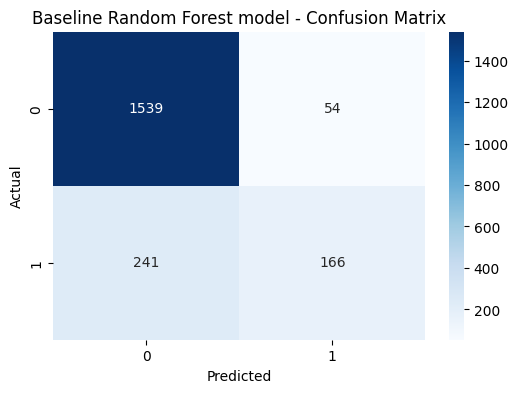

In [5]:
# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Baseline Random Forest model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Cross-validation for Baseline Model

In [6]:
# The stratified K-Fold object
kfold = cv_strategy

# Compute CV ROC-AUC 
cv_scores = cross_val_score(
    clf,          # pipeline
    X, y,         # full dataset (pipeline will split it internally)
    cv=kfold,
    scoring='roc_auc',
    n_jobs=-1
)

print("Cross-Validation ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC:", np.mean(cv_scores))
print("Std Dev:", np.std(cv_scores))


Cross-Validation ROC-AUC scores: [0.82919422 0.82699265 0.83516336 0.82460427 0.84022081]
Mean CV ROC-AUC: 0.8312350620418723
Std Dev: 0.005697466887794103


### Cross-validation for Other matrices

In [7]:
metrics = ['accuracy', 'precision', 'recall', 'f1']

for m in metrics:
    scores = cross_val_score(clf, X, y, cv=kfold, scoring=m)
    print(f"{m.capitalize()} — Mean: {scores.mean():.4f}, Std: {scores.std():.4f}")
## Took 3.25 minutes to run cross-validation for all metrics

Accuracy — Mean: 0.8502, Std: 0.0042
Precision — Mean: 0.7411, Std: 0.0277
Recall — Mean: 0.4085, Std: 0.0188
F1 — Mean: 0.5261, Std: 0.0143


### Hyperparameter Tuning using Randomized Search

In [8]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}

grid_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    n_iter=10,              # Only 10 combinations
    cv=CV_FOLDS,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
    
)

## Tuning Hyperparameters for the Random Forest Model

To enhance the baseline Random Forest effectiveness, I utilized RandomizedSearchCV to explore a broad array of hyperparameters. Rather than evaluating all potential combinations (which would be time-consuming and unnecessary at this point), I restricted the search to 10 randomly chosen configurations. This method enables the model to investigate the parameter space effectively while maintaining computational feasibility.

The grid contains parameters that directly affect the complexity of tree growth, the model's sampling process, and the selection of features.

I selected **ROC-AUC** as the evaluation metric since it provides a more equitable perspective on model effectiveness, particularly in churn prediction where recognizing the minority class is vital. The cross-validation folds guarantee that every parameter configuration is evaluated consistently, and n_jobs=-1 enables the search to operate concurrently for quicker execution.

This adjustment phase helps find a model setup that performs better than the baseline without requiring a comprehensive search.


### Fit Randomized Search

In [9]:
grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'classifier__bootstrap': [True, False], 'classifier__max_depth': [None, 5, ...], 'classifier__max_features': ['sqrt', 'log2', ...], 'classifier__min_samples_leaf': [1, 2, ...], ...}"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


### Best Model Output

In [10]:
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

Best Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10, 'classifier__bootstrap': True}
Best ROC-AUC: 0.8487547071683794


### Evaluate Tuned Model

In [11]:
best_model = grid_search.best_estimator_

preds = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)[:, 1]


Test ROC-AUC: 0.8473280676670507

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1593
           1       0.55      0.67      0.61       407

    accuracy                           0.82      2000
   macro avg       0.73      0.77      0.75      2000
weighted avg       0.84      0.82      0.83      2000



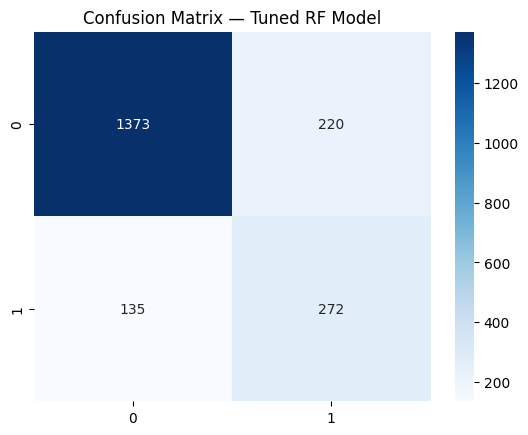

In [12]:
print("Test ROC-AUC:", roc_auc_score(y_test, probs))
print("\nClassification Report:")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Tuned RF Model")
plt.show()


## Adjusted Model: Classification Summary

Following tuning, the Random Forest exhibited significantly different behavior - particularly regarding the churn class. The model improved in recognizing churners, even though overall accuracy decreased slightly.

### Class 0 - No-Churn

- Accuracy: **0.91**

- Recall: **0.86**

- F1-niveau: **0,89**

### Class 1 - Attrition

- Accuracy: **0.55**

- Recall: **0.67**

- F1-score: **0.61**

The recall for churners rose significantly from **0.41 -> 0.67**.

This is a significant enhancement as the aim of churn prediction is to recognize customers likely to depart.

### General Metrics

- Precision: **0.82**

- Macro F1: **0.75**

- Weighted F1: **0.83**

Even though accuracy decreased a bit (from 0.85 to 0.82), the model grew considerably more beneficial for the business as it detects more churners — which is the actual goal

In [13]:
# This is for 05_model_comparison.ipynb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

print("\nrf_metrics = {")
print(f"    'Accuracy': {accuracy:.4f},")
print(f"    'Precision': {precision:.4f},")
print(f"    'Recall': {recall:.4f},")
print(f"    'F1-Score': {f1:.4f},")
print(f"    'ROC-AUC': {roc_auc:.4f}")
print("}")


rf_metrics = {
    'Accuracy': 0.8225,
    'Precision': 0.5528,
    'Recall': 0.6683,
    'F1-Score': 0.6051,
    'ROC-AUC': 0.8473
}


### Model Evaluation

In [14]:
from sklearn.inspection import PartialDependenceDisplay

In [15]:
top_features = [
    "CreditScore",
    "Age",
    "EstimatedSalary",
    "Tenure",
    "Balance",
    "NumOfProducts"
]

c:\Users\FORAM\OneDrive\Desktop\ML_McMaster\ML_Term_Project\bankingenv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\FORAM\OneDrive\Desktop\ML_McMaster\ML_Term_Project\bankingenv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


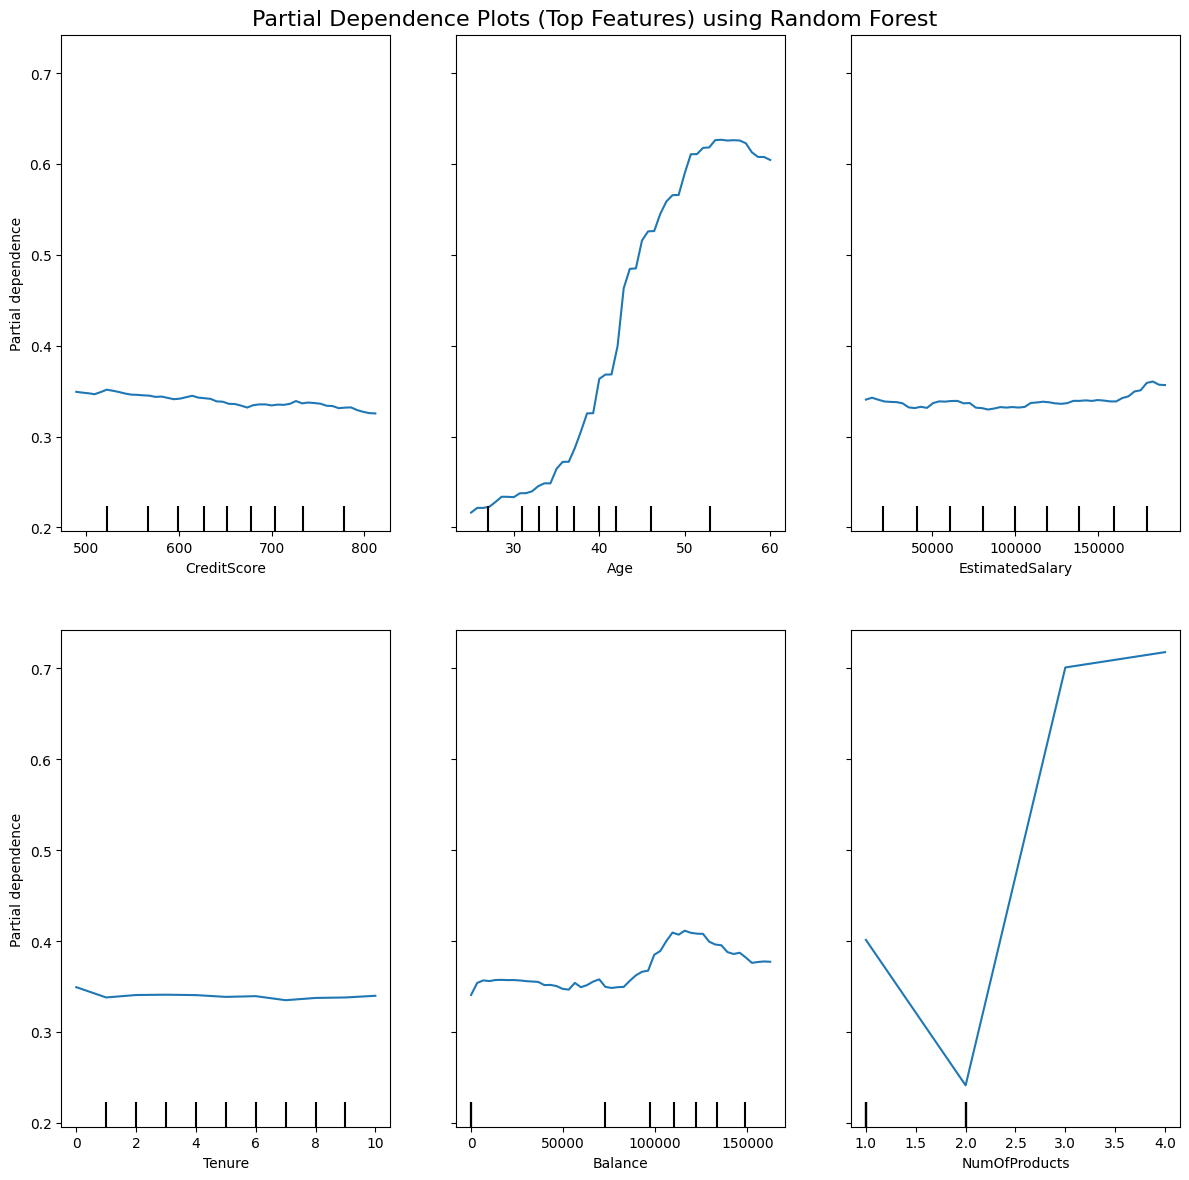

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))

PartialDependenceDisplay.from_estimator(
    best_model,          # your tuned RF pipeline
    X_train,             # raw input (pipeline transforms automatically)
    top_features,        
    grid_resolution=50,
    ax=ax
)

plt.suptitle("Partial Dependence Plots (Top Features) using Random Forest", fontsize=16)
plt.tight_layout()
plt.show()


## Interpretation of Partial Dependence Plot (Random Forest)

The Partial Dependence Plots allow us to see how each feature affects the model's predicted probability of churn while keeping all other features unchanged. These patterns indicate the direction in which each feature influences the prediction.

### Credit Rating

The impact of credit score on churn remains fairly constant. As the credit score rises, the predicted likelihood of churn declines slightly, although the variation is minimal. This indicates that credit score alone is not a significant factor in driving churn.

### Age

Age demonstrates the most significant trend among all characteristics. The likelihood of churn increases significantly beginning around age 35 and persists in rising until approximately age 55 - 60. This reinforces previous results indicating that older clients are much more prone to leave.

### Salary

Compensation has a negligible impact on the churn predictions of the model. The line stays almost level, suggesting that income level has little impact on churn risk in this dataset.

### Tenue

Tenure also exhibits a steady relationship. No matter how long a customer has been with the bank, the anticipated likelihood of churn varies only slightly. This indicates that tenure is not a significant factor in churn within this model.

### Balance

Balance indicates a small increase in churn probability at mid-to-high balance levels (approximately 80K-120K). This supports the notion that customers with high balances are more unpredictable and could change banks because of dissatisfaction or more attractive offers elsewhere.

### NumOfProducts

This variable displays a distinct trend: customers possessing precisely **two** products exhibit the lowest anticipated churn, whereas possessing **three or more** products leads to a significant rise. This aligns with previous clustering findings where customers with numerous products showed inconsistent engagement.


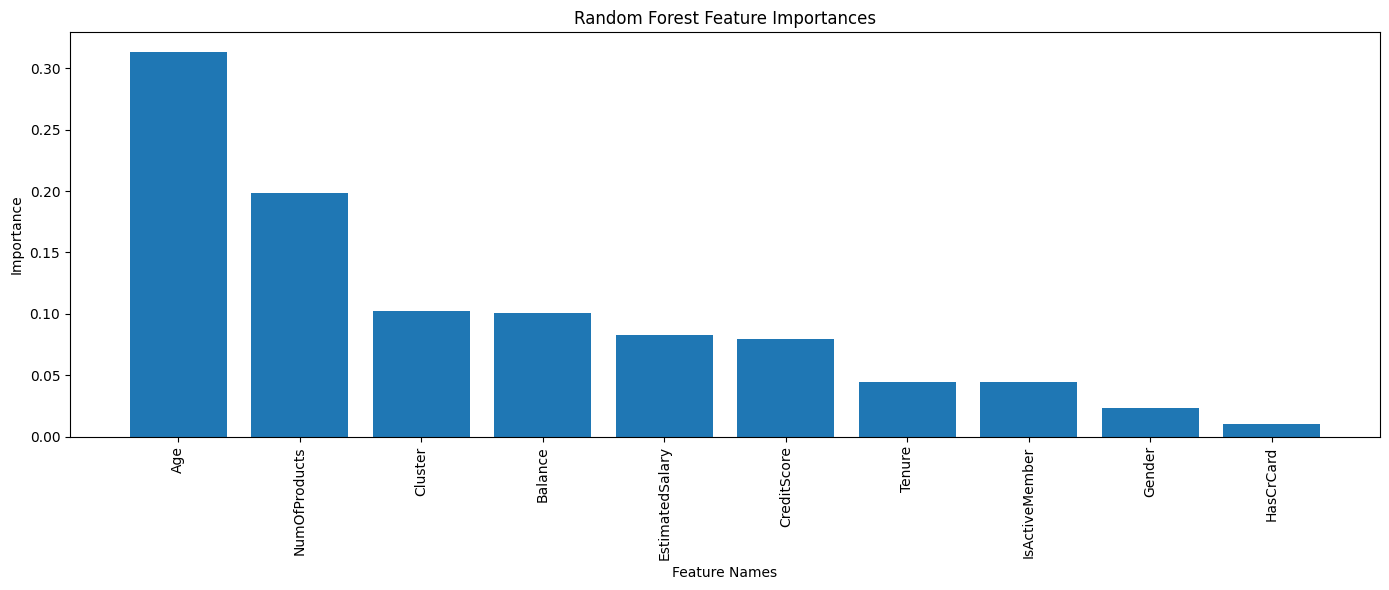

In [17]:

fitted_model = best_model


pre = fitted_model.named_steps['preprocessor']


num_features = numeric_cols


ohe = pre.named_transformers_['cat']
ohe_cols = pre.transformers_[1][2]   # the list of categorical cols used by the encoder

if len(ohe_cols) == 0:
    # No categorical columns
    cat_features = []
else:
    # There are categorical columns
    cat_features = list(ohe.get_feature_names_out(ohe_cols))

# Combine the feature names
feature_names = num_features + cat_features


importances = fitted_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(14, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Feature Names")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

## Random Forest Feature Importance Analysis

The feature importance plot displays the variables that have the highest impact on the customer churn prediction by the Random Forest. This provides us with knowledge about the model's decision-making process and gives insights into the foremost customer characteristics associated with churn behavior.

### 1. Age (Highest Importance)
Age is clearly the most important factor in the analysis. This is consistent with the data trends: older people are more likely to leave the service while younger ones are less likely. The model is capturing the trend of age directly.

### 2. Number of Products
The second most important feature is the number of products that the customer has. Often, the customers with a small number or the ones with a very high number of products exhibit distinct churn behavior, therefore, this factor is effective in telling the model apart between the stable and the at-risk customers.

### 3. Balance
Balance also plays an important part. High-balance customers were in different clusters and the model considers these spending and savings patterns to be significant indicators of the likelihood of one being a churner.

### 4. Estimated Salary, Credit Score, and Cluster
These mid-level features still provide useful signals:

- **Estimated Salary** gives a sense of financial stability.
- **Credit Score** helps differentiate risk-averse vs. risk-prone customers.
- **Cluster** captures behavioral patterns created earlier during segmentation, and the model is leveraging those group-level differences.

### 5. Lower-Importance Features
A few features contribute less to prediction:

- **IsActiveMember**  
- **Tenure**  
- **Gender**  
- **HasCrCard**

Their lower importance doesn’t mean they are irrelevant — only that, relative to the stronger predictors, they add less unique information. For example, tenure and credit card status may be mildly related to churn.